<a href="https://colab.research.google.com/github/Murcicrum/Identificador-de-medio/blob/main/identificador_de_medios_clasificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Armado de dataset

Una vez conseguidos los titulares de las noticias limpios procedimos a preprocesarlos con un lematizador. Buscamos cuales eran los lematizadores disponibles en idioma español y luego de hacer algunas pruebas con cada uno optamos por utilizar NLTK.

Una vez tenidos entonces todos los titulares lematizados y sin stopwords, el armado del dataset consistió en guardar cada titular junto con el medio del que provino en un archivo .csv.
Este archivo se encuentra en mi [repositorio](https://github.com/Murcicrum/Identificador-de-medio) bajo el nombre data_norm.csv

#Clasificador

Cargamos el dataset final

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import drive

#drive.mount('/content/drive/')
#path = 'drive/MyDrive/Física/LaboDatos/TP Final/data_norm.csv'
#df = pd.read_csv(path)

url_csv = 'https://github.com/Murcicrum/Identificador-de-medio/raw/main/data_norm.csv'
df = pd.read_csv(url_csv)

Recuerdo acá que el análisis exploratorio del dataset estuvo a cargo de mi compañera y que a continuación solo muestro lo correspondiente al clasificador. Sin embargo cabe destacar la siguiente característica del dataset, viendo con qué medios estoy trabajando y cuan representado está cada uno:

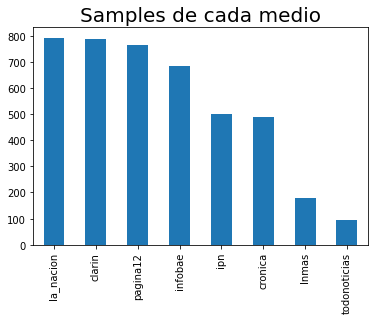

In [ ]:
df.medio.value_counts().plot(kind='bar')
plt.title('Samples de cada medio', size=20);

En la mayoría de los medios obtuvimos al rededor de ~600 muestras promedio, siendo Crónica y La Nación los medios con menos y más muestras respectivamente. Sin embargo vemos que los medios TN y LN+ la cantidad de muestras es significativamente menos, con lo cual ambos estarán subrepresentados en el clasificador. Atribuímos este desbalance a que estos medios son originalmente televisados y no impresos/escritos, y que podrían no tener mucha actividad en Twitter.

En vista de esto y considerando que LN+ y TN son principalmente la 'arista' audiovisual de La Nación y Clarín, estando estrechamente correlacionadas, decidimos eliminarlas de la etapa de clasificación. Sin embargo creemos que los ligeros desbalances en los otros medios pueden ser tratados adecuadamente con las opciones que brinda el clasificador y por esto continuan sin alteraciones.

In [ ]:
df = df[ (df.medio!='lnmas') & (df.medio!='todonoticias') ]

Ahora si, dividimos el dataset en un conjunto de entrenamiento y testeo para proceder con el entrenamiento del modelo.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

data = df['titulares_norm'].tolist()
label = df['medio'].tolist()

counter = CountVectorizer(stop_words=None) # ahora armo el vectorizer. no uso la opcion de remover stopwords porque ya los removi en un paso anterior
allX = counter.fit_transform(data) # transformo

####Validación cruzada

In [ ]:
from sklearn.model_selection import train_test_split

# separo en ambos datasets
X_train, X_test, y_train, y_test = train_test_split(allX, label, )

In [ ]:
print('Tamaño test: ', X_train.shape, len(y_train))
print('Tamaño train:', X_test.shape,  len(y_test))

Tamaño test:  (3015, 7697) 3015
Tamaño train: (1006, 7697) 1006


El método de naive-Bayes depende de un hiperparámetro $\alpha$ relacionado con XXXX

Para definir entonces qué valor de $\alpha$ hará más PRECISO? utilizo la técnica de k-folds con el set de testeo para un rango de valores del hiperparámetro. Para cada hiperparámetro calculo el AUC medio obtenido de los (5) folds y veo con cual se consigue el la máxima PRECISIÓN?

20
40
60
80
100
120
140
160
180


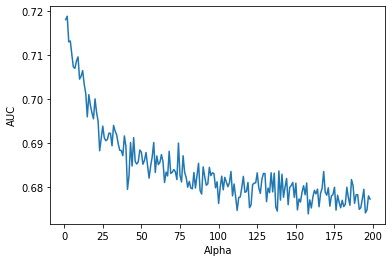

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True) 
skf.get_n_splits(allX, label) 

alpha_values = np.arange(1,199) # valores de alpha que probamos
auc_values = [] 

y_train = np.array(y_train)
for alpha in alpha_values: # me muevo en alpha
  auc_temp = []
  
  if alpha%20 == 0:   print(r'Calculando AUC para $\alpha$=',alpha)
    
  for train_index, val_index in skf.split(X_train, y_train): # va generando los indices que corresponden a train y test en cada fold
      
      X_tra, X_val = X_train[train_index], X_train[val_index]  # arma que es dato de entrenamiento y qué es dato de evaluación
      y_tra, y_val = y_train[train_index], y_train[val_index]  # idem con los targets
      
      mnb = MultinomialNB(alpha=alpha) # armo el clasificador Naive Bayes
      mnb.fit(X_tra, y_tra) # entreno
      
      probas = mnb.predict_proba(X_val) # estimo probabilidades
      auc_temp.append(roc_auc_score(y_val, probas, average='macro', multi_class='ovo'))   # AUC con datos de evaluación
      #Si están poco desbalanceados sacar average='macro' y poner multi_class='ovr'

  auc_values.append(np.mean(auc_temp)) # asigno el promedio de los AUC

plt.figure()
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.plot(alpha_values, auc_values);

Viendo esto decidimos tomar el valor $\alpha=1$ para entrenar finalmente a nuestro clasificador.

In [ ]:
from sklearn.metrics import confusion_matrix

mnb = MultinomialNB(alpha=1)

mnb.fit(X_train,y_train)

y_pred = mnb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[58 20 31 13 50 30]
 [16 56  9  7 13  9]
 [39 13 56 16 37 22]
 [12  2  9 85  4 10]
 [44 22 28 19 55 25]
 [35 11 23 33 27 67]]


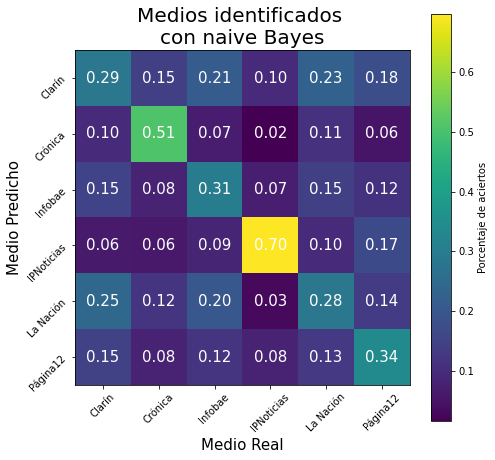

In [ ]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

cm = confusion_matrix(y_test, y_pred, normalize='true')
graf = ax.imshow(cm.T)

fig.colorbar(graf, label='Porcentaje de aciertos')

#Coloco el numeríto dentro de cada cuadradito
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, f'{cm.T[i,j]:.2f}',
                       ha="center", va="center", color='w', fontsize=15)

labels = ['Clarín', 'Crónica', 'Infobae', 'IPNoticias', 'La Nación', 'Página12']
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)

ax.set_title('Medios identificados \ncon naive Bayes', fontsize=20 )
ax.set_ylabel('Medio Predicho', fontsize=15)
ax.tick_params(axis='y', labelrotation=45)
ax.set_xlabel('Medio Real',fontsize=15)
ax.tick_params(axis='x', labelrotation=45)

#Conclusiones

Lo primero a destacar de este gráfico es que sobre la diagonal se obtienen los valores más altos de la fila y columna, lo que indica que el clasificador tiene cierta utilidad para esta tarea.

Luego, vemos también que en particular el clasificador pudo reconocer con gran exactitud los titulares de IPNoticias, con un ~70% de aciertos. También Crónica es bastante bien identificable para este clasificador, con un ~50% de aciertos.

Y la última observación relevante es que el clasificador confunde los titulares de Clarín, Infobae y La nación en la misma medida. Recordemos también que los titulares con los que se hizo este trabajo no pertenecen a ninguna categoría periodística particular (e.g. policiales, política, entretenimiento, etc) sino que son aquellos que cada medio decidió compartir/publicitar a través de Twitter, y sin embargo esta confusión en la clasificación sugiere ciertas similitudes entre estos titulares.

Este clasificador podría entonces ser utilizado para obtener alguna medida respecto a la orientación política que toma la linea editorial de cada diario si restringimos su entrenamiento a notas de corte político!